In [1]:
import os
import copy
from skimage import io, color
import scipy.stats
import numpy as np
from pathlib import Path
import cv2

from sprite_cutter.sprite_cutter import *
from sprite_cutter.find_sprites import *
from sprite_cutter.helpers import timing
from sprite_cutter.classes import Rectangle, Point

In [2]:
# List of sheet paths
base_path = '..'
sheets = [os.path.join(base_path,'sheets',x) for x in os.listdir("../sheets") if '.png' in x]
print(f"Choose an index for the list below [0-{len(sheets)-1}]")
[print(f"{i}. {x}") for i, x in enumerate(os.listdir(os.path.join(base_path, 'sheets')))]
index = int(input())

Choose an index for the list below [0-63]
0. allen-walker.png
1. anna-kyoyama.png
2. arale-norimaki.png
3. bobobo-bo-bo-bobo.png
4. caramelman-j.png
5. dio.png
6. don-patch-poppa-rocks.png
7. dr-mashirito.png
8. eve.png
9. franky.png
10. frieza.png
11. fuusuke.png
12. gintoki-sakata.png
13. gohan-super-saiyan-2.png
14. gohan-super-saiyan.png
15. goku-super-saiyan.png
16. goku.png
17. gon-freecss.png
18. gotenks-super-saiyan.png
19. gotenks.png
20. heihachi-edajima.png
21. hiei.png
22. ichigo-kurosaki.png
23. jaguar-junichi.png
24. jotaro-kujo.png
25. kagura.png
26. kakashi-hatake.png
27. kazuki-muto.png
28. kenshin-himura.png
29. kenshiro.png
30. killua-zaoldyeck.png
31. kinnikuman.png
32. kurama.png
33. lenalee-lee.png
34. majin-buu.png
35. momotaro-tsurugi.png
36. monkey-d-luffy-2nd-gear.png
37. monkey-d-luffy.png
38. nami-perfect-clima-tact.png
39. nami.png
40. naruto-uzumaki-nine-tails-kyubi.png
41. naruto-uzumaki.png
42. neuro-nogami.png
43. nico-robin.png
44. pegasus-seiya.png
45

In [3]:
# Example sheet
sheet = sheets[index]
aname = new_path_name(sheet, base_path)

# Create directory
Path(aname).mkdir(parents=True, exist_ok=True)

In [4]:
# Read img
img = cv2.imread(sheet)
img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)

# Get height and width of img
height, width = img.shape[0], img.shape[1]

# Reshape img to 2d array of rgba values
colors = img.reshape(-1,4)

# Get value with most occurrences and use as bgColor
bgColor = scipy.stats.mode(colors).mode[0]

In [5]:
y = 169
x = 70
point = np.array([y,x])

In [95]:
bitmap = find_contiguous(img, point,bgColor,bitmap)

In [101]:
neighbors(point, bitmap)

array([[168,  69,   0,   1],
       [168,  70,   0,   1],
       [168,  71,   0,   1],
       [169,  69,   0,   1],
       [169,  70,   0,   1],
       [169,  71,   0,   1],
       [170,  69,   0,   1],
       [170,  70,   0,   1],
       [170,  71,   0,   1]], dtype=int64)

In [92]:
bitmap = create_bitmap(img, bgColor)

In [6]:
from numba import jit

@jit(nopython=True)
def matches_bg(img, bgColor):
    base = np.zeros((img.shape[0],img.shape[1],1), dtype=np.int64)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            base[y,x,0] = colors_match(img[y,x], bgColor)
    return base

@jit(nopython=True)
def colors_match(color, bgColor):
    return np.all(color == bgColor)

@jit(nopython=True)
def unique_neighbors(n1, n2):
    return np.vstack((n1, n2))

@jit(nopython=True)
def find_contiguous(image, point, bgColor, bitmap, marker = 1, margin=1):
    unvisited = neighbors(point, image, bitmap, margin)
    #print(unvisited)
    while unvisited.shape[0] > 0:
        currentPoint, unvisited = unvisited[0], unvisited[1:]
        if bitmap[currentPoint[0],currentPoint[1],2] != 0:
            continue
        currNeighbors = neighbors(point, image, bitmap, margin=6)
        if currNeighbors.shape[0] > 0:
            unvisited = unique_neighbors(unvisited,currNeighbors)
        #print(unvisited)
        bitmap[currentPoint[0],currentPoint[1],2] = marker
    return bitmap

# Checks to find neighbors in bitmap. Must not be visited (index 2) or bgColor (index 3)
@jit(nopython=True)
def neighbors(point, bitmap, margin=1):
    y = point[0]
    x = point[1]
    n = bitmap[max(y-margin,0):min(y+margin+1,img.shape[0]), 
               max(x-margin,0):min(x+margin+1,img.shape[1])].copy().reshape(-1,4)
    return n
    #return n[(n[:,2] == 0) & (n[:,3] == 0)][:,0:2]

# Creates an array based off img with y,x coordinates and boolean for visits
@jit(nopython=True)
def create_bitmap(img, bgColor=None):
    YY = np.arange(img.shape[0]).repeat(img.shape[1]).reshape((-1,img.shape[1]))
    XX = np.arange(img.shape[1]).repeat(img.shape[0]).reshape((-1,img.shape[0])).T
    zeros = np.zeros((img.shape[0],img.shape[1],1), dtype=np.uint8)
    bgmatches = matches_bg(img, bgColor)
    bitmap = np.vstack((YY.ravel(),XX.ravel(),zeros.ravel(),bgmatches.ravel())).T.reshape(img.shape[0],img.shape[1],4)
    return bitmap

@jit(nopython=True)
def neighbors_p(point, img, bitmap, margin=1):
    y = point[0]
    x = point[1]
    width = img.shape[1]
    height = img.shape[0]
    yn = np.arange(start=-margin, stop=margin+1) + y

    # if out of bounds, convert to zero
    yn[ yn < 0] = 0
    yn[ yn >= height ] = 0

    # multiply y by width
    yn = width * yn

    yn = np.vstack((yn,np.ones((margin*2+1),dtype=np.float64))).T

    xn = (np.arange(start=-margin, stop=margin+1) + x)

    # if out of bounds, convert to zero
    xn[xn < 0] = 0
    xn[xn >= width ] = 0

    xn = np.vstack((np.ones((margin*2+1),dtype=np.float64),xn))

    # dot product
    indexes = np.dot(yn,xn).flatten().astype(np.int64).copy()
    indexes = indexes[indexes != 0]
    n = bitmap[indexes]
    return n[(n[:,2] == 0) & (n[:,3] == 0)][:,0:2]

# Creates an array based off img with y,x coordinates and boolean for visits
@jit(nopython=True)
def create_bitpy(img, bgColor=None):
    YY = np.arange(img.shape[0]).repeat(img.shape[1]).reshape((-1,img.shape[1]))
    XX = np.arange(img.shape[1]).repeat(img.shape[0]).reshape((-1,img.shape[0])).T
    zeros = np.zeros((img.shape[0],img.shape[1],1), dtype=np.uint8)
    bgmatches = matches_bg(img, bgColor)
    bitmap = np.vstack((YY.ravel(),XX.ravel(),zeros.ravel(),bgmatches.ravel())).T.reshape(img.shape[0]*img.shape[1],4)
    return bitmap

@jit(nopython=True)
def find_sprites(image, backgroundColor, margin=3):
    #workingImage = copy.deepcopy(image)
    bitmap = create_bitpy(image, backgroundColor)
    spriteRectangles = []
    marker = 0
    for y in range(0, image.shape[0]):
        for x in range(0, image.shape[1]):
            color = image[y,x]
            # Checks if color is not bg and point has not been seen
            if bitmap[y,x,2] == 0 and colors_match(color, bgColor):
                # Iterate found sprite 
                marker += 1
                bitmap[y,x,2] = marker
                point = np.array([y,x])
                print("Found Sprite!")
                #print(f"Found sprite {marker} starting at ({point[1]},{point[0]})")
                bitmap = find_contiguous(image, point, backgroundColor, bitmap, marker, margin)
                spritePlot = bitmap[np.where(bitmap[:,:,2] == marker)]
                #print(spritePlot)
                spriteRectangle = Rectangle(spritePlot)
                #print(f"The identified sprite has an area of {spriteRectangle.area}")
                spriteRectangles.append(spriteRectangle)
    #print(f"Found {marker} sprites.")
    return sorted(spriteRectangles)

In [8]:
bpy = create_bitpy(img,bgColor)

In [132]:
neighbors(point, bitmap)

array([[168,  69,   0,   1],
       [168,  70,   0,   1],
       [168,  71,   0,   1],
       [169,  69,   0,   1],
       [169,  70,   0,   1],
       [169,  71,   0,   1],
       [170,  69,   0,   1],
       [170,  70,   0,   1],
       [170,  71,   0,   1]], dtype=int64)

In [ ]:
bitmap[max(y-margin,0):min(y+margin+1,img.shape[0]), 
               max(x-margin,0):min(x+margin+1,img.shape[1])].copy().reshape(-1,4)

In [146]:
idx1 = img.shape[1] * (y+1) + x
idx2 = img.shape[1] * (y) + x
idx3 = img.shape[1] * y + x-70
bpy[idx3]

array([169,   0,   0,   1], dtype=int64)

In [148]:
img.shape[1]

1136

In [230]:
x

70

In [570]:
margin = 1000

In [34]:
y = point[0]
x = point[1]
width = img.shape[1]
margin=80

In [36]:
yn = np.arange(start=-margin, stop=margin+1) + y

# if out of bounds, convert to zero
yn[ yn < 0] = 0
yn[ yn >= bpy.shape[0] ] = 0

# multiply y by width
yn = width * yn

yn = np.vstack((yn,np.ones((margin*2+1),dtype=np.int64))).T

xn = (np.arange(start=-margin, stop=margin+1) + x)

# if out of bounds, convert to zero
xn[xn < 0] = 0
xn[xn >= width ] = 0

xn = np.vstack((np.ones((margin*2+1),dtype=np.int64),xn))

# dot product
indexes = np.dot(yn,xn).flatten()
indexes = indexes[indexes != 0]

In [39]:
n[(n[:,2] == 0) & (n[:,3] == 0)][:,0:2]

array([[141,  55],
       [142,  56],
       [142,  57],
       ...,
       [249,  52],
       [249,  53],
       [249,  55]], dtype=int64)

In [38]:
n = bpy[indexes]

In [26]:
bpy

array([[   0,    0,    0,    1],
       [   0,    1,    0,    1],
       [   0,    2,    0,    1],
       ...,
       [4773, 1133,    0,    0],
       [4773, 1134,    0,    0],
       [4773, 1135,    0,    0]], dtype=int64)

In [44]:
n=neighbors_p(point,img, bpy, margin=6
            )

In [46]:
n

array([[163,  64],
       [163,  65]], dtype=int64)

In [471]:
n[np.argsort(n[:,0])]

array([[167,  68,   0,   1],
       [167,  70,   0,   1],
       [167,  72,   0,   1],
       [168,  69,   0,   1],
       [168,  70,   0,   1],
       [168,  71,   0,   1],
       [169,  68,   0,   1],
       [169,  69,   0,   1],
       [169,  71,   0,   1],
       [169,  72,   0,   1],
       [170,  71,   0,   1],
       [170,  70,   0,   1],
       [170,  69,   0,   1],
       [171,  72,   0,   1],
       [171,  70,   0,   1],
       [171,  68,   0,   1]], dtype=int64)

In [417]:
n.sort(axis=1)

In [418]:
n

array([[  0,   1,  69, 168],
       [  0,   1,  71, 170],
       [  0,   1,  69, 169],
       [  0,   1,  71, 169],
       [  0,   1,  70, 168],
       [  0,   1,  70, 170],
       [  0,   1,  71, 168],
       [  0,   1,  69, 170]], dtype=int64)

In [391]:
neighbors(point, bitmap, margin=2).shape

(25, 4)

In [335]:
img.shape[1] * y + x + xn

array([192053, 192054, 192055])

In [360]:
np.flip(xn)

array([ 1, -1])

In [368]:
n1

array([[168,  69,   0,   1],
       [170,  71,   0,   1]], dtype=int64)

In [369]:
n2

array([[169,  69,   0,   1],
       [169,  71,   0,   1]], dtype=int64)

In [370]:
n3

array([[168,  70,   0,   1],
       [170,  70,   0,   1]], dtype=int64)

In [371]:
n4

array([[168,  71,   0,   1],
       [170,  69,   0,   1]], dtype=int64)

In [107]:
bitmap = create_bitmap(img, bgColor)

In [230]:
m = 6
y = 19
x = 43
point = np.array([y,x])
color = img[point[0],point[1]]

In [31]:
 np.array([], dtype=np.int32)

array([], dtype=int32)

In [119]:
# find sprite bounding boxes
find_sprites_t = timing(find_sprites)

spriteRectangles = find_sprites(img, bgColor, margin=6)
spriteRectangles = sorted(spriteRectangles)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(int64, 3d, F), UniTuple(array(int64, 1d, C) x 2))
 
There are 22 candidate implementations:
[1m      - Of which 20 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(array(int64, 3d, F), UniTuple(array(int64, 1d, C) x 2))':[0m
[1m       No match.[0m
[1m      - Of which 2 did not match due to:
      Overload in function 'GetItemBuffer.generic': File: numba\core\typing\arraydecl.py: Line 162.
        With argument(s): '(array(int64, 3d, F), UniTuple(array(int64, 1d, C) x 2))':[0m
[1m       Rejected as the implementation raised a specific error:
         NotImplementedError: only one advanced index supported[0m
  raised from C:\Users\dfa23\Anaconda3\lib\site-packages\numba\core\typing\arraydecl.py:65
[0m
[0m[1mDuring: typing of intrinsic-call at <ipython-input-118-e8a6e4fb55bc> (71)[0m
[1m
File "<ipython-input-118-e8a6e4fb55bc>", line 71:[0m
[1mdef find_sprites(image, backgroundColor, margin=3):
    <source elided>
                bitmap = find_contiguous(image, point, backgroundColor, bitmap, marker, margin)
[1m                spritePlot = bitmap[np.where(bitmap[:,:,2] == marker)]
[0m                [1m^[0m[0m


In [12]:
bitmap

NameError: name 'bitmap' is not defined

In [11]:
import math
maxWidth = max([s.width for s in spriteRectangles])
maxHeight = max([s.height for s in spriteRectangles])
w = math.ceil(maxWidth/8)*8
h = math.ceil(maxHeight/8)*8

In [13]:
# Write individual files of each sprite
trans = remove_bgColor(img, bgColor)
    
for i, r in enumerate(spriteRectangles):
    subimg =  subset_image(trans, r)
    #print(i)
    #print(subimg)
    #newsub = add_space(subimg, w, h)
    cv2.imwrite(f"{aname}/{i:03}.png",subimg)

# Write original sheet with transparent bg
cv2.imwrite(f"{aname}/original_image.png",trans)

# Adds in visual bounding boxes
boxTrans = add_boxes(trans,spriteRectangles)
cv2.imwrite(f"{aname}/bounding_boxes.png", boxTrans)

[255  60  60 255]


True

In [62]:
img[80,30]

array([  8,   8,   8, 255], dtype=uint8)

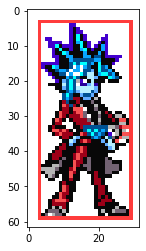

In [38]:
#Plot subimg

import matplotlib.pyplot as plt
r = spriteRectangles[0] # rectangle
m = 3 # margin

plt.figure(0)
plt.imshow(boxTrans[r.minHeight-m:r.maxHeight+m,r.minWidth-m:r.maxWidth+m])
plt.show()

In [231]:
%%timeit
XX,YY = np.meshgrid(np.arange(img.shape[1]),np.arange(img.shape[0]))
zeros = np.zeros((img.shape[0],img.shape[1],1), dtype=np.uint8)
bitmap = np.vstack((YY.ravel(),XX.ravel(),zeros.ravel())).T.reshape(img.shape[0],img.shape[1],3)

6.67 ms ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
